### SMOT

  File "c:\Users\malle\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


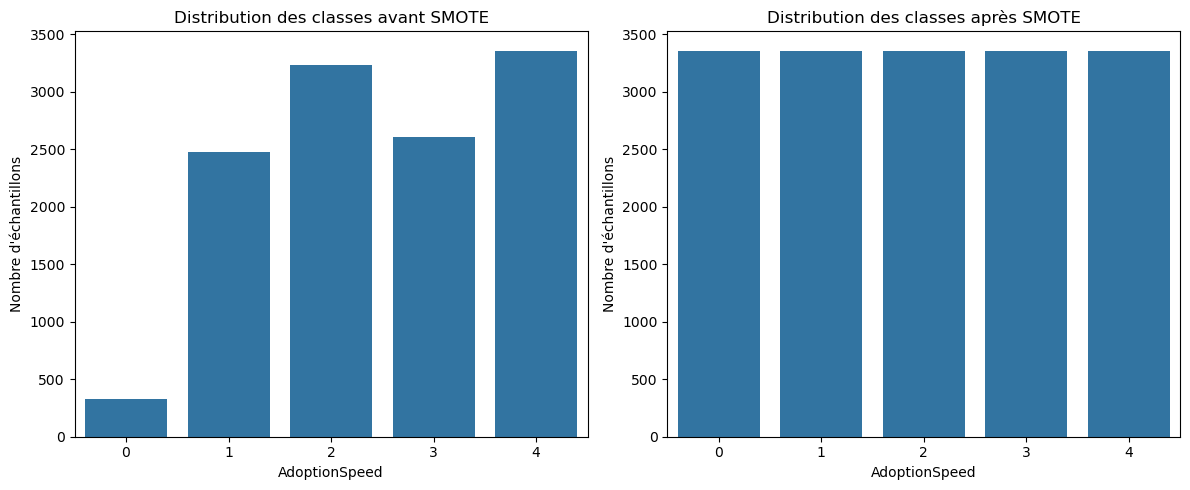


Précision moyenne (validation croisée, entraînement) : 0.4437

--- Évaluation sur le test set original (déséquilibré) ---
Précision (Precision): 0.3679
Rappel (Recall): 0.3505
F1-score: 0.3487


<Figure size 1200x500 with 0 Axes>

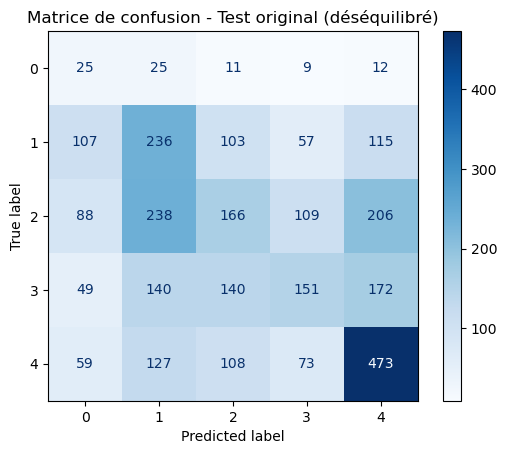


--- Évaluation sur le test set équilibré (SMOTE) ---
Précision (Precision): 0.3847
Rappel (Recall): 0.3969
F1-score: 0.3835


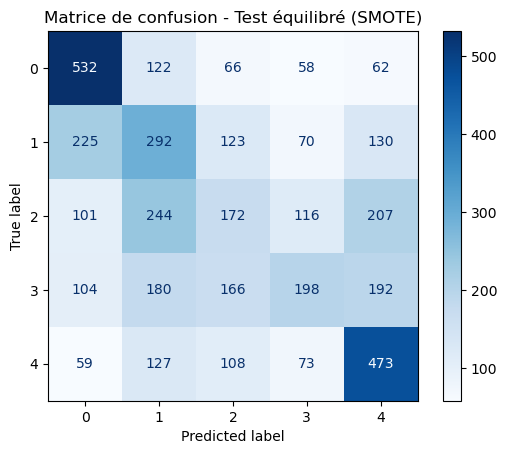


--- Calcul avec mlxtend (100 répétitions, test original) ---
MSE : 2.4320
Biais (mlxtend): 1.9731
Variance (mlxtend): 0.4588


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from mlxtend.evaluate import bias_variance_decomp
from imblearn.over_sampling import SMOTE
import warnings
import matplotlib.pyplot as plt
import seaborn as sns


warnings.filterwarnings("ignore")


df = pd.read_csv('train.csv')

df = df.drop(columns=['PetID', 'Quantity'])

features = ['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3',
            'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
            'Health', 'PhotoAmt', 'VideoAmt', 'Fee']
target = 'AdoptionSpeed'

X = df[features]
y = df[target]



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

X_test_smote, y_test_smote = smote.fit_resample(X_test, y_test)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train, order=sorted(y_train.unique()))
plt.title("Distribution des classes avant SMOTE")
plt.xlabel("AdoptionSpeed")
plt.ylabel("Nombre d'échantillons")

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_smote, order=sorted(y_train_smote.unique()))
plt.title("Distribution des classes après SMOTE")
plt.xlabel("AdoptionSpeed")
plt.ylabel("Nombre d'échantillons")
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 5))



scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test) 
X_test_smote_scaled = scaler.transform(X_test_smote) 

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

cv_scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring='precision_macro')
train_accuracy = cv_scores.mean()
print(f'\nPrécision moyenne (validation croisée, entraînement) : {train_accuracy:.4f}')

model.fit(X_train_smote_scaled, y_train_smote)

y_test_pred = model.predict(X_test_scaled)


precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=1)

print(f'\n--- Évaluation sur le test set original (déséquilibré) ---')
print(f'Précision (Precision): {precision:.4f}')
print(f'Rappel (Recall): {recall:.4f}')
print(f'F1-score: {f1:.4f}')

labels = sorted(y.unique())
cm = confusion_matrix(y_test, y_test_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Matrice de confusion - Test original (déséquilibré)")
plt.grid(False)
plt.show()

y_test_smote_pred = model.predict(X_test_smote_scaled)

precision_smote = precision_score(y_test_smote, y_test_smote_pred, average='weighted', zero_division=1)
recall_smote = recall_score(y_test_smote, y_test_smote_pred, average='weighted', zero_division=1)
f1_smote = f1_score(y_test_smote, y_test_smote_pred, average='weighted', zero_division=1)

print(f'\n--- Évaluation sur le test set équilibré (SMOTE) ---')
print(f'Précision (Precision): {precision_smote:.4f}')
print(f'Rappel (Recall): {recall_smote:.4f}')
print(f'F1-score: {f1_smote:.4f}')

cm_smote = confusion_matrix(y_test_smote, y_test_smote_pred, labels=labels)
disp_smote = ConfusionMatrixDisplay(confusion_matrix=cm_smote, display_labels=labels)
disp_smote.plot(cmap='Blues')
plt.title("Matrice de confusion - Test équilibré (SMOTE)")
plt.grid(False)
plt.show()


print(f'\n--- Calcul avec mlxtend (100 répétitions, test original) ---')
try:
    mse, bias_mlxtend, var_mlxtend = bias_variance_decomp(
        model, X_train_smote_scaled, y_train_smote.values,
        X_test_scaled, y_test.values,
        loss='mse',
        num_rounds=100,
        random_seed=42
    )
    print(f'MSE : {mse:.4f}')
    print(f'Biais (mlxtend): {bias_mlxtend:.4f}')
    print(f'Variance (mlxtend): {var_mlxtend:.4f}')
except Exception as e:
    print("❌ Erreur lors du calcul avec mlxtend :", str(e))

### Analyse des valeurs aberrantes (outliers)

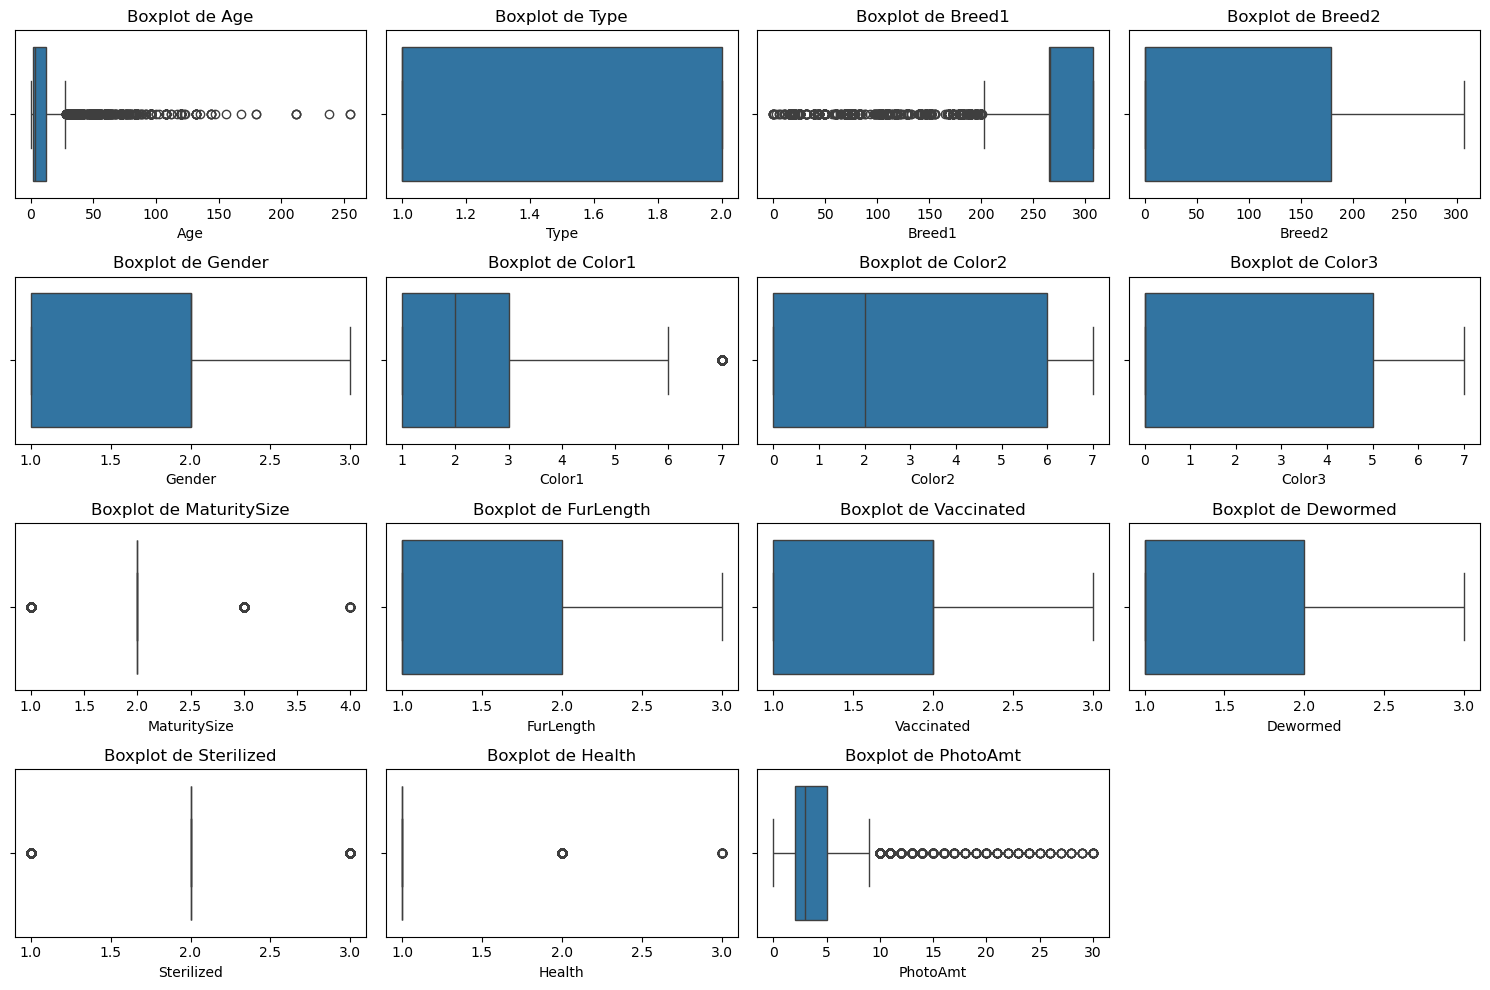

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv('data_clean.csv')

features = ['Age','Type','Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3',
            'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
            'Health', 'PhotoAmt']

df_numeric = df[features]

plt.figure(figsize=(15, 10))

for i, feature in enumerate(df_numeric.columns, 1):
    plt.subplot(4, 4, i)  
    sns.boxplot(x=df_numeric[feature])
    plt.title(f'Boxplot de {feature}')
    plt.xlabel(feature)


plt.tight_layout() 
plt.show()

### Analyse des tendances globales des variables catégorielles

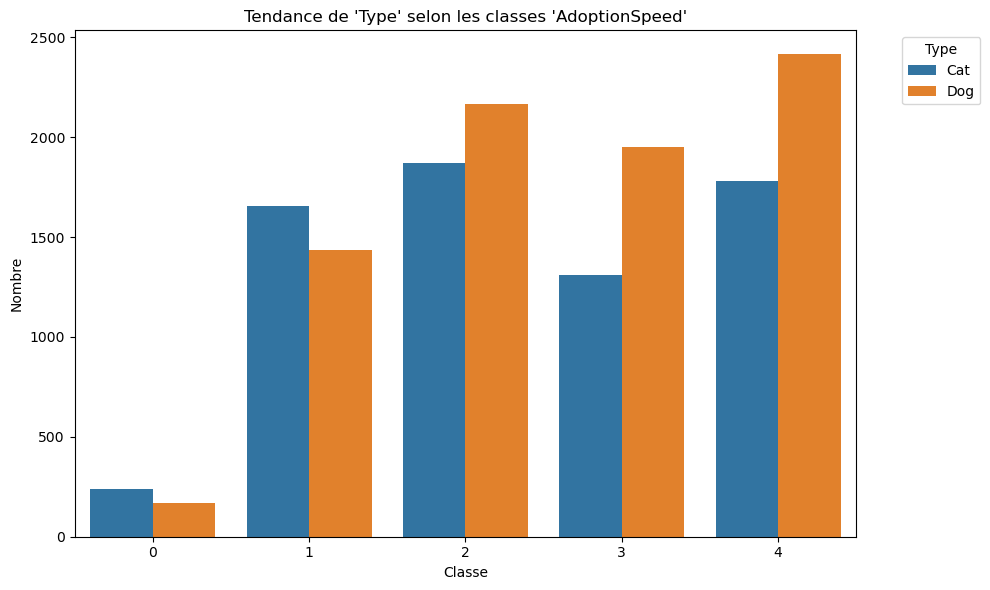

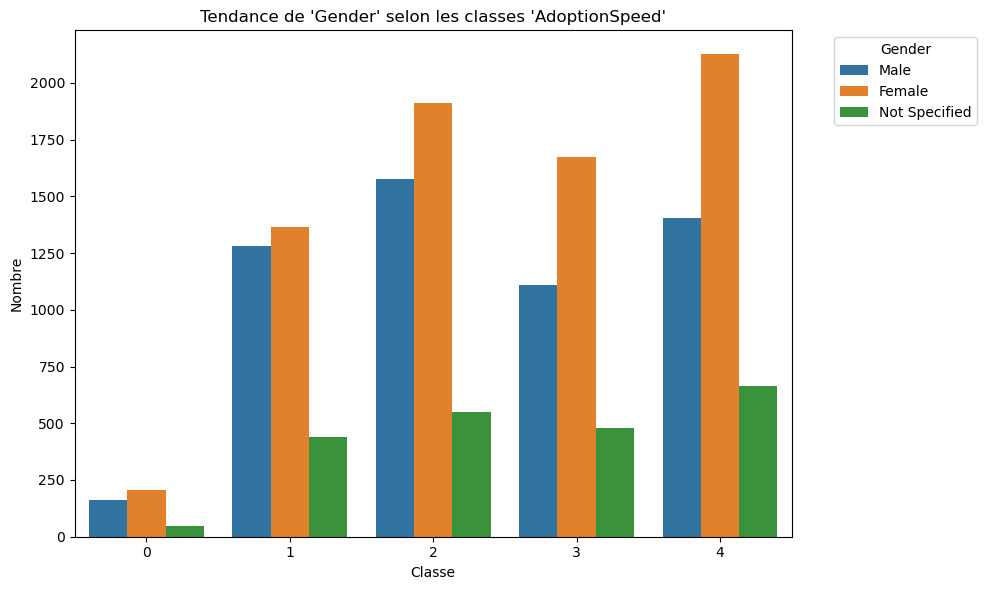

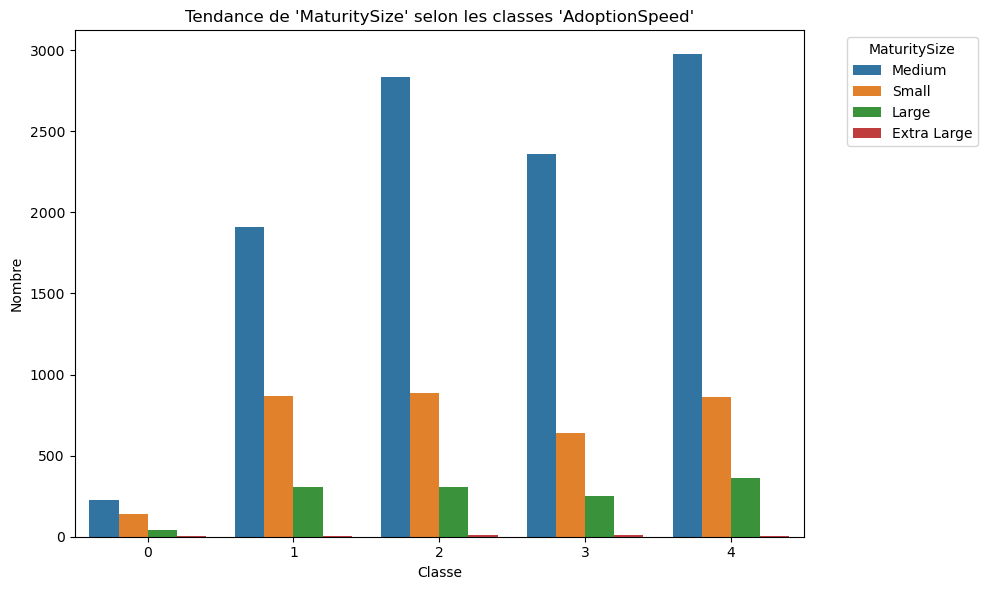

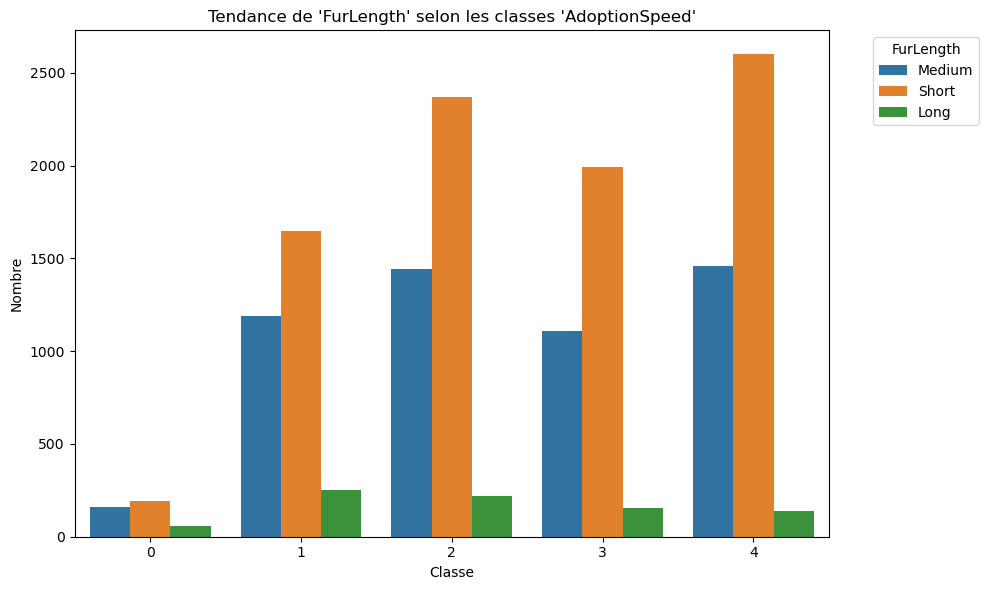

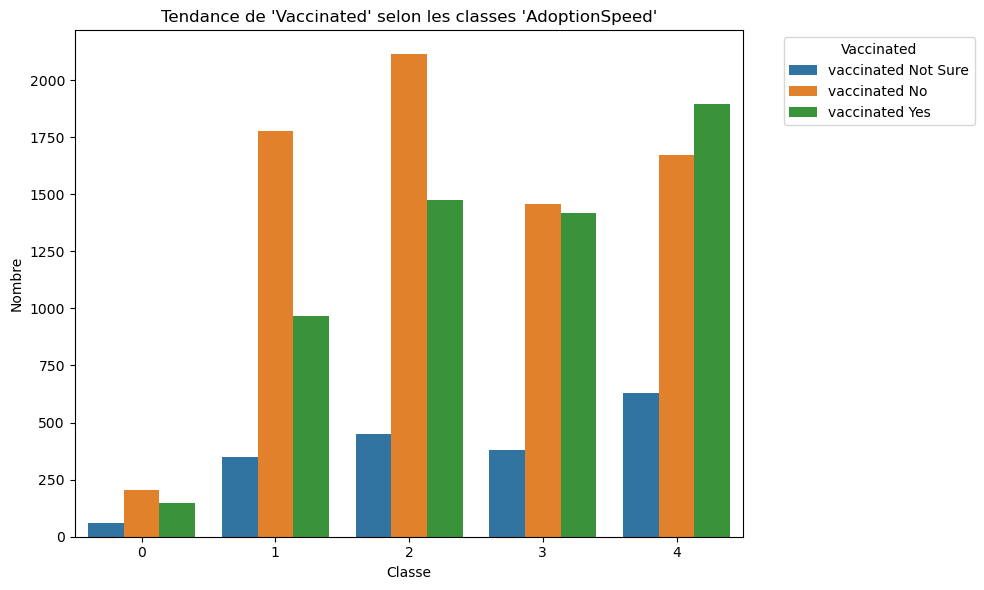

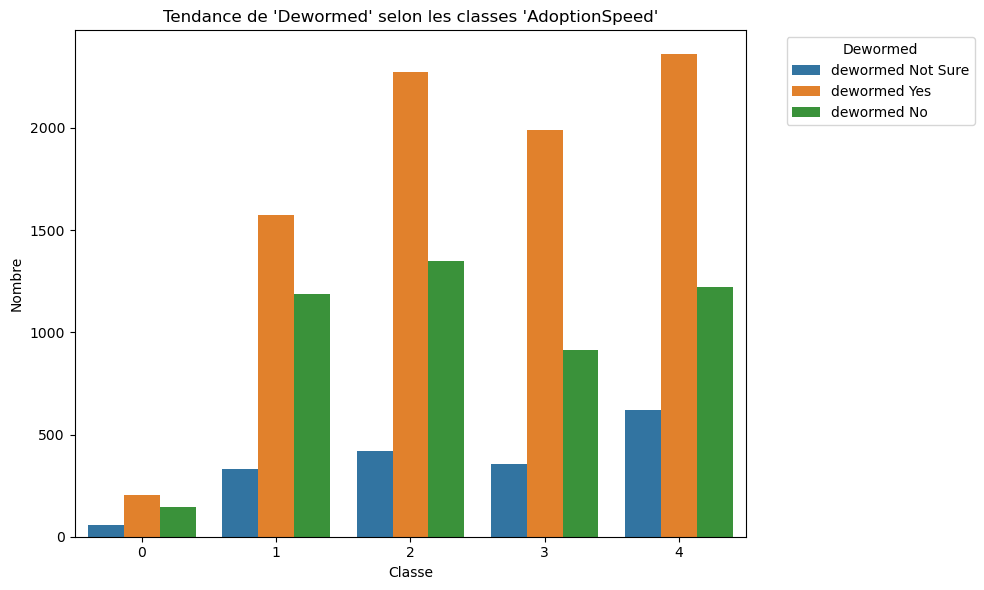

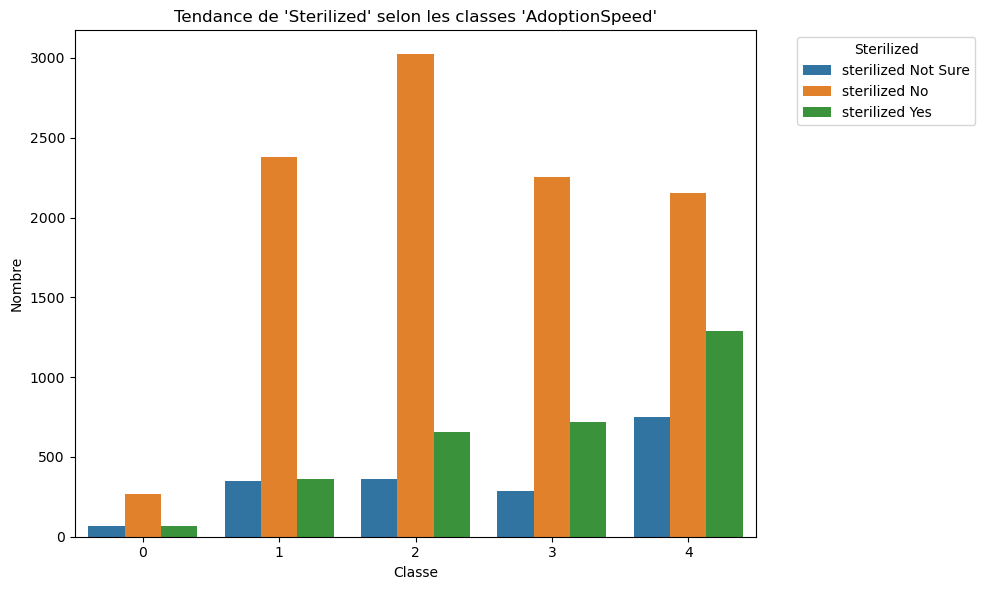

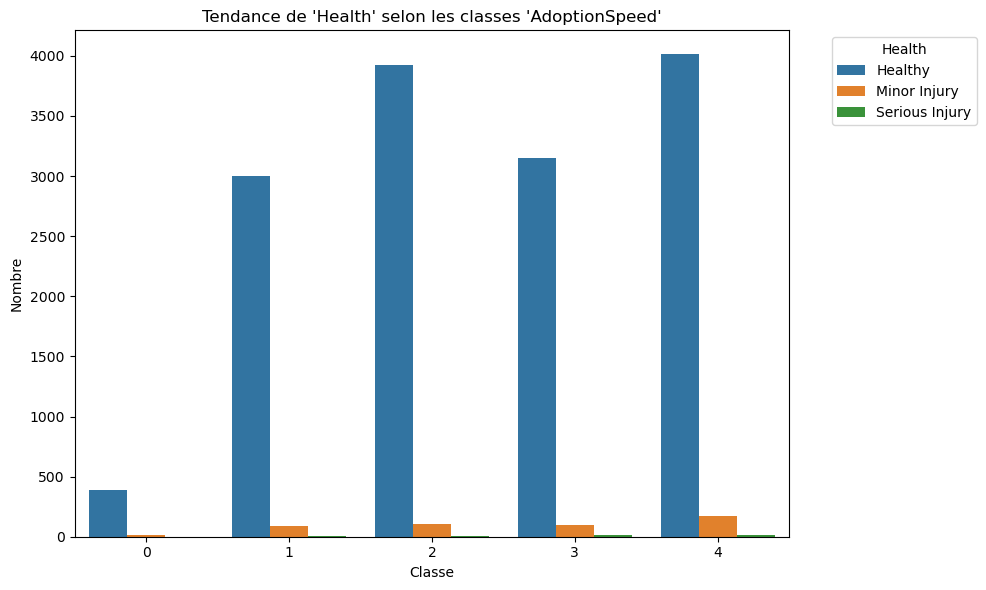

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

df = pd.read_csv('data_clean.csv')

class_column = 'AdoptionSpeed'

categorical_columns = [
    'Type', 'Gender', 'MaturitySize', 'FurLength',
    'Vaccinated', 'Dewormed', 'Sterilized', 'Health'
]

df = df[categorical_columns + [class_column]]

df['Type'] = df['Type'].map({1: 'Dog', 2: 'Cat'})
df['Gender'] = df['Gender'].map({1: 'Male', 2: 'Female'})

df['MaturitySize'] = df['MaturitySize'].map({
    0: 'maturity Not Specified',
    1: 'Small',
    2: 'Medium',
    3: 'Large',
    4: 'Extra Large'
})

df['FurLength'] = df['FurLength'].map({
    0: 'fur_length Not Specified',
    1: 'Short',
    2: 'Medium',
    3: 'Long'
})

df['Vaccinated'] = df['Vaccinated'].map({
    1: 'vaccinated Yes',
    2: 'vaccinated No',
    3: 'vaccinated Not Sure'
})

df['Dewormed'] = df['Dewormed'].map({
    1: 'dewormed Yes',
    2: 'dewormed No',
    3: 'dewormed Not Sure'
})

df['Sterilized'] = df['Sterilized'].map({
    1: 'sterilized Yes',
    2: 'sterilized No',
    3: 'sterilized Not Sure'
})

df['Health'] = df['Health'].map({
    0: 'health Not Specified',
    1: 'Healthy',
    2: 'Minor Injury',
    3: 'Serious Injury'
})

df[categorical_columns] = df[categorical_columns].fillna('Not Specified')
for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=class_column, hue=col)
    plt.title(f"Tendance de '{col}' selon les classes '{class_column}'")
    plt.xlabel("Classe")
    plt.ylabel("Nombre")
    plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


### ACM  analyse composante multiple

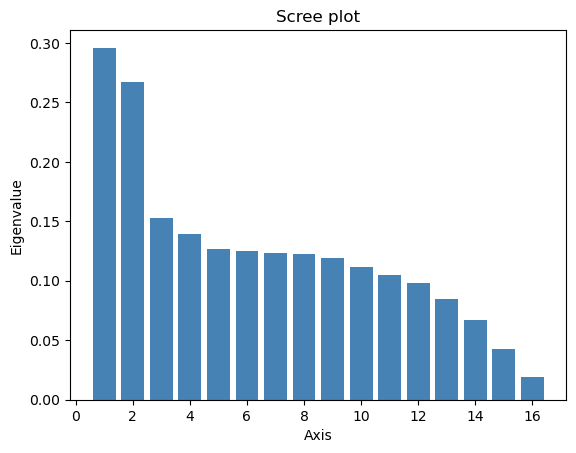

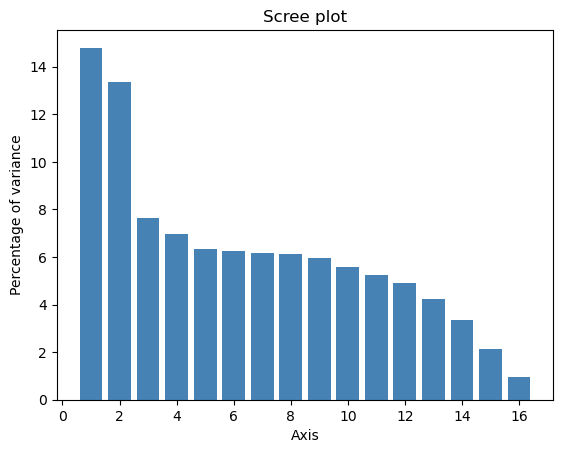

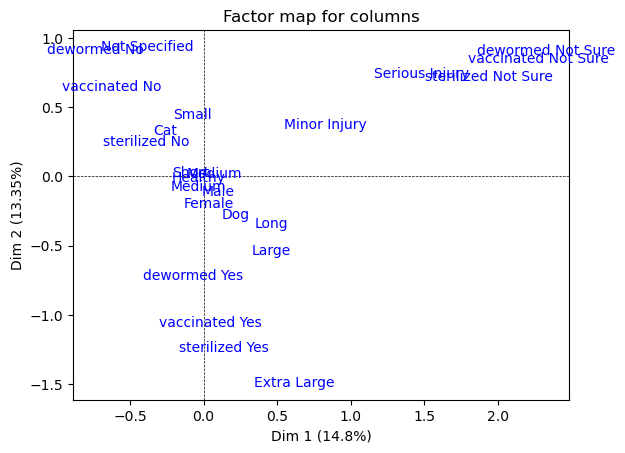

In [ ]:
import pandas as pd
import fanalysis.mca as mca
import warnings

warnings.filterwarnings("ignore")

df = pd.read_csv('train.csv')

categorical_columns = [
    'Type', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health'
]
df = df[categorical_columns]

df['Type'] = df['Type'].map({1: 'Dog', 2: 'Cat'})
df['Gender'] = df['Gender'].map({1: 'Male', 2: 'Female'})

maturity_map = {
    0: 'maturity Not Specified',
    1: 'Small',
    2: 'Medium',
    3: 'Large',
    4: 'Extra Large'
}
df['MaturitySize'] = df['MaturitySize'].map(maturity_map)

fur_length_map = {
    0: 'fur_length Not Specified',
    1: 'Short',
    2: 'Medium',
    3: 'Long'
}
df['FurLength'] = df['FurLength'].map(fur_length_map)

vaccinated_map = {
    1: 'vaccinated Yes',
    2: 'vaccinated No',
    3: 'vaccinated Not Sure'
}
df['Vaccinated'] = df['Vaccinated'].map(vaccinated_map)

dewormed_map = {
    1: 'dewormed Yes',
    2: 'dewormed No',
    3: 'dewormed Not Sure'
}
df['Dewormed'] = df['Dewormed'].map(dewormed_map)

sterilized_map = {
    1: 'sterilized Yes',
    2: 'sterilized No',
    3: 'sterilized Not Sure'
}
df['Sterilized'] = df['Sterilized'].map(sterilized_map)

health_map = {
    0: 'health Not Specified',
    1: 'Healthy',
    2: 'Minor Injury',
    3: 'Serious Injury'
}
df['Health'] = df['Health'].map(health_map)

df[categorical_columns] = df[categorical_columns].fillna('Not Specified')

X = df[categorical_columns].values
my_mca = mca.MCA(row_labels=df.index.values, var_labels=categorical_columns)

my_mca.fit(X)
my_mca.plot_eigenvalues()
my_mca.plot_eigenvalues(type="percentage")
my_mca.mapping_col(num_x_axis=1, num_y_axis=2)





### Modèle regrouper les class (0+1+2) et (3+4) XGbost

 Recherche des meilleurs hyperparamètres...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
✅ Meilleurs paramètres : {'colsample_bytree': 0.7, 'learning_rate': 0.005, 'max_depth': 8, 'n_estimators': 100, 'reg_lambda': 1, 'subsample': 0.8}

 Évaluation croisée (5-fold) sur les données d'entraînement
Moyenne precision_macro (CV) : 0.6423

 Évaluation sur le jeu de test
Précision : 0.6489051265568127
Rappel    : 0.6472157385795265
F1-score  : 0.6459639279296084


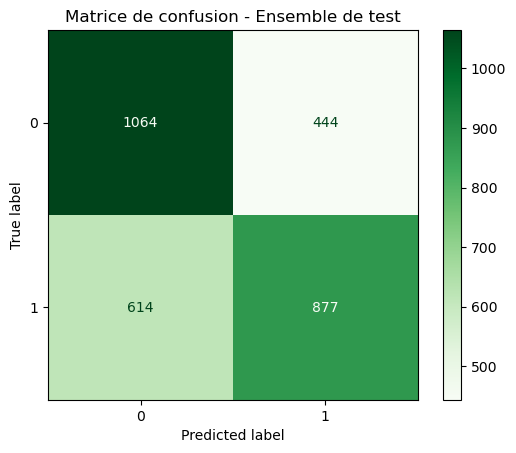


 Analyse Biais/Variance
MSE      : 0.3553
Biais²   : 0.2941
Variance : 0.0612


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from mlxtend.evaluate import bias_variance_decomp
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

df = pd.read_csv('train.csv')

df['AdoptionSpeed'] = df['AdoptionSpeed'].replace({0:1, 1:1, 2:1, 3:2, 4:2})
df['PureBreed'] = df['Breed2'].apply(lambda x: 0 if x != 0 else 1)

df['breed1_chat'] = np.where(df['Type'] == 2, df['Breed1'], -1000)
df['breed1_chien'] = np.where(df['Type'] == 1, df['Breed1'], -1000)
df['breed2_chat'] = np.where(df['Type'] == 2, df['Breed2'], -1000)
df['breed2_chien'] = np.where(df['Type'] == 1, df['Breed2'], -1000)

df = df.drop(['Breed1', 'Breed2'], axis=1)

features = [
    'Age', 'Type','breed1_chat', 'breed1_chien', 'breed2_chat', 'breed2_chien', 
    'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 
    'Dewormed', 'Sterilized', 'PhotoAmt', 'Fee', 'PureBreed', 
    'VideoAmt', 'Health'
]


target = 'AdoptionSpeed'

X = df[features]
y = df[target] - 1  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y.values, stratify=y, test_size=0.2, random_state=42
)


model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.005, 0.05, 0.1],
    'max_depth': [6, 8, 10],
    'reg_lambda': [1, 3], 
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.7, 1.0]  
}

print(" Recherche des meilleurs hyperparamètres...")
grid = GridSearchCV(model, param_grid, scoring='precision', cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("✅ Meilleurs paramètres :", grid.best_params_)

best_model = grid.best_estimator_

print("\n Évaluation croisée (5-fold) sur les données d'entraînement")
scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='precision_macro')
print(f"Moyenne precision_macro (CV) : {scores.mean():.4f}")

y_pred = best_model.predict(X_test)

print("\n Évaluation sur le jeu de test")
print("Précision :", precision_score(y_test, y_pred, average='weighted'))
print("Rappel    :", recall_score(y_test, y_pred, average='weighted'))
print("F1-score  :", f1_score(y_test, y_pred, average='weighted'))

cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique())).plot(cmap='Greens')
plt.title("Matrice de confusion - Ensemble de test")
plt.grid(False)
plt.show()

print("\n Analyse Biais/Variance")
try:
    mse, bias, var = bias_variance_decomp(
        best_model,
        X_train, y_train, 
        X_test, y_test,
        loss='mse',
        num_rounds=100,
        random_seed=123
    )
    print(f"MSE      : {mse:.4f}")
    print(f"Biais²   : {bias:.4f}")
    print(f"Variance : {var:.4f}")
except Exception as e:
    print("Impossible de calculer biais/variance :", str(e))



### Modèle regrouper les class (1+2) et (3+4)

🔍 Recherche des meilleurs hyperparamètres...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
✅ Meilleurs paramètres : {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'reg_lambda': 3, 'subsample': 1.0}

📊 Évaluation croisée (5-fold) sur les données d'entraînement
Moyenne precision_macro (CV) : 0.6481

📈 Évaluation - Ensemble de test
Précision : 0.6420646452299615
Rappel    : 0.6403839561193007
F1-score  : 0.6400823285469821


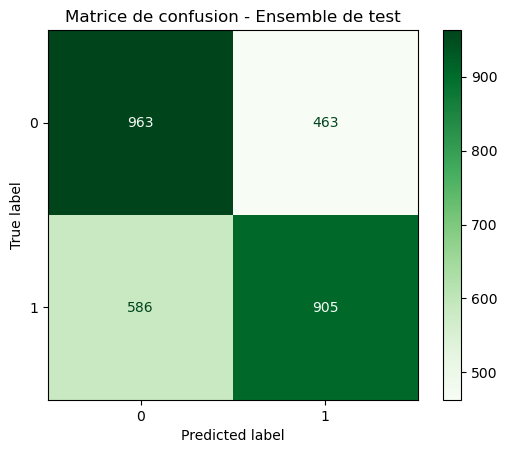


📉 Analyse Biais/Variance
MSE      : 0.3681
Biais²   : 0.3038
Variance : 0.0643


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from mlxtend.evaluate import bias_variance_decomp
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

df = pd.read_csv('train.csv')

df = df[df['AdoptionSpeed'] != 0]

df['AdoptionSpeed'] = df['AdoptionSpeed'].replace({1: 1, 2: 1, 3: 2, 4: 2})

df['PureBreed'] = df['Breed2'].apply(lambda x: 0 if x != 0 else 1)

df['breed1_chat'] = np.where(df['Type'] == 2, df['Breed1'], -1000)
df['breed1_chien'] = np.where(df['Type'] == 1, df['Breed1'], -1000)
df['breed2_chat'] = np.where(df['Type'] == 2, df['Breed2'], -1000)
df['breed2_chien'] = np.where(df['Type'] == 1, df['Breed2'], -1000)

df = df.drop(['Breed1', 'Breed2'], axis=1)

features = [
    'Age','Type', 'breed1_chat', 'breed1_chien', 'breed2_chat', 'breed2_chien', 
    'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 
    'Dewormed', 'Sterilized', 'PhotoAmt', 'Fee', 'PureBreed', 
    'VideoAmt', 'Health'
]
target = 'AdoptionSpeed'

X = df[features]
y = df[target] - 1  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y.values, stratify=y, test_size=0.2, random_state=42
)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.005, 0.05, 0.1],
    'max_depth': [6, 8, 10],
    'reg_lambda': [1, 2, 3], 
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

print(" Recherche des meilleurs hyperparamètres...")
grid = GridSearchCV(model, param_grid, scoring='precision', cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Meilleurs paramètres :", grid.best_params_)

best_model = grid.best_estimator_

print("\n Évaluation croisée (5-fold) sur les données d'entraînement")
scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='precision_macro')
print(f"Moyenne precision_macro (CV) : {scores.mean():.4f}")

y_pred = best_model.predict(X_test)

print("\n Évaluation - Ensemble de test")
print("Précision :", precision_score(y_test, y_pred, average='weighted'))
print("Rappel    :", recall_score(y_test, y_pred, average='weighted'))
print("F1-score  :", f1_score(y_test, y_pred, average='weighted'))

cm = confusion_matrix(y_test, y_pred, labels=sorted(np.unique(y)))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(np.unique(y))).plot(cmap='Greens')
plt.title("Matrice de confusion - Ensemble de test")
plt.grid(False)
plt.show()

print("\n Analyse Biais/Variance")
try:
    mse, bias, var = bias_variance_decomp(
        best_model,
        X_train, y_train, 
        X_test, y_test,
        loss='mse',
        num_rounds=100,
        random_seed=123
    )
    print(f"MSE      : {mse:.4f}")
    print(f"Biais²   : {bias:.4f}")
    print(f"Variance : {var:.4f}")
except Exception as e:
    print(" Impossible de calculer biais/variance :", str(e))




### Code pour extraire les sentiment depuis un text (creation de data set sentiment)

In [ ]:
import pandas as pd
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


nltk.download('vader_lexicon')


analyzer = SentimentIntensityAnalyzer()


train_data = pd.read_csv('train.csv')

required_columns = ['PetID', 'Description']
for col in required_columns:
    if col not in train_data.columns:
        raise ValueError(f"La colonne '{col}' n'existe pas dans le fichier CSV.")


def get_sentiment_scores(text):
    if pd.isna(text) or not isinstance(text, str):
        return {'pos': 0.0, 'neg': 0.0, 'neu': 0.0, 'compound': 0.0}
    return analyzer.polarity_scores(text)


sentiment_scores = train_data['Description'].apply(get_sentiment_scores)


sentiment_df = pd.DataFrame(sentiment_scores.tolist())

sentiment_df['PetID'] = train_data['PetID']


sentiment_df = sentiment_df[['PetID', 'pos', 'neg', 'neu', 'compound']]

sentiment_df.to_csv('sentiment.csv', index=False)

print("Aperçu des premières lignes du fichier 'sentiment.csv' :")
print(sentiment_df.head())

print("\n✅ Fichier 'sentiment.csv' créé avec succès !")

### Analyse description

In [3]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from rich.console import Console
from rich.table import Table

# Initialize VADER and rich console
analyzer = SentimentIntensityAnalyzer()
console = Console()

# Sample sentences
data = pd.DataFrame({
    'PetID': ['001', '002'],
    'Description': [
        "This dog is loving, playful and super friendly.",      # Positive
        "This cat is aggressive, scared and hates people."      # Negative
    ]
})

# Analyze sentiment
def get_sentiment_scores(text):
    return analyzer.polarity_scores(text)

sentiment_scores = data['Description'].apply(get_sentiment_scores)
sentiment_df = pd.DataFrame(sentiment_scores.tolist())
sentiment_df['PetID'] = data['PetID']
sentiment_df['Description'] = data['Description']

# Create styled table
table = Table(title="🐾 Pet Description Sentiment Analysis", show_lines=True)

table.add_column("PetID", style="cyan", no_wrap=True)
table.add_column("Description", style="white")
table.add_column("Positive", style="green")
table.add_column("Negative", style="red")
table.add_column("Neutral", style="yellow")

for _, row in sentiment_df.iterrows():
    table.add_row(
        row['PetID'],
        row['Description'],
        f"{row['pos']:.2f}",
        f"{row['neg']:.2f}",
        f"{row['neu']:.2f}",
    )

# Print the result
console.print(table)


                           🐾 Pet Description Sentiment Analysis                            
┏━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ PetID ┃ Description                                      ┃ Positive ┃ Negative ┃ Neutral ┃
┡━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ 001   │ This dog is loving, playful and super friendly.  │ 0.78     │ 0.00     │ 0.22    │
├───────┼──────────────────────────────────────────────────┼──────────┼──────────┼─────────┤
│ 002   │ This cat is aggressive, scared and hates people. │ 0.00     │ 0.60     │ 0.40    │
└───────┴──────────────────────────────────────────────────┴──────────┴──────────┴─────────┘

In [27]:
import pandas as pd

# Charger les données
df = pd.read_csv('train.csv')



# Filtrer pour la classe 0
class_0 = df[df['AdoptionSpeed'] == 0]

# Compter les chiens (Type == 1) et les chats (Type == 2)
dogs_class_0 = class_0[class_0['Type'] == 1].shape[0]
cats_class_0 = class_0[class_0['Type'] == 2].shape[0]

# Afficher les résultats
print(f"🐶 Nombre de chiens dans la classe 0 : {dogs_class_0}")
print(f"😺 Nombre de chats dans la classe 0 : {cats_class_0}")

🐶 Nombre de chiens dans la classe 0 : 170
😺 Nombre de chats dans la classe 0 : 240
